In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv


In [23]:
data = pd.read_csv("/kaggle/input/diabetes-prediction-dataset/diabetes_prediction_dataset.csv")

In [24]:
data.head()

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0


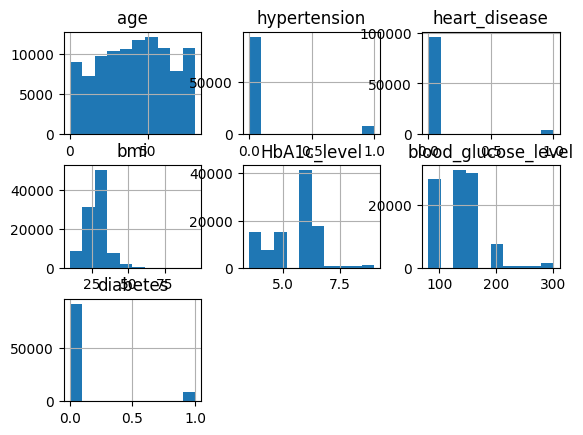

In [25]:
import matplotlib.pyplot as plt

data.hist()
plt.show()

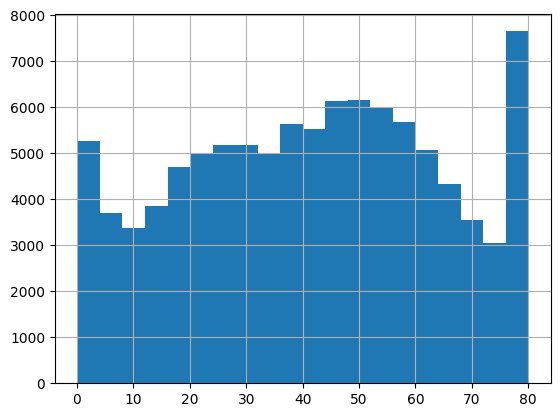

In [26]:
data["age"].hist(bins=20)
plt.show()

In [27]:
data["smoking_history"].value_counts()

smoking_history
No Info        35816
never          35095
former          9352
current         9286
not current     6447
ever            4004
Name: count, dtype: int64

<Axes: >

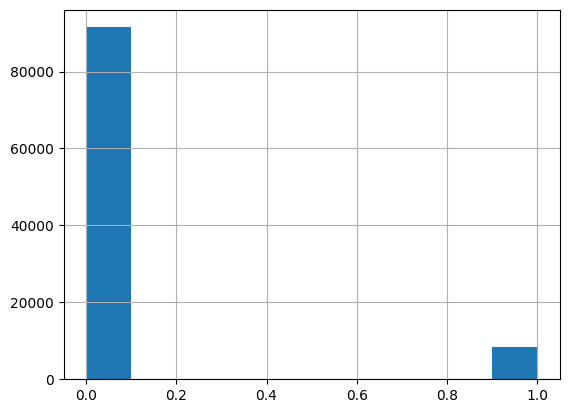

In [28]:
data["diabetes"].hist()

In [29]:
data["smoking_history"] = data["smoking_history"].replace("ever", "never")

In [30]:
data["smoking_history"].unique()

array(['never', 'No Info', 'current', 'former', 'not current'],
      dtype=object)

In [31]:
len(data)

100000

In [32]:
import sklearn
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

knn_imputer = KNNImputer(n_neighbors=4, weights="distance", missing_values=0)
smoke_pipeline = make_pipeline(OrdinalEncoder(categories=[["No Info", "never", "former", "not current", "current"]]), knn_imputer)

In [33]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(data["smoking_history"], data["heart_disease"])

chi2, p, _, _ = chi2_contingency(contingency_table)

In [34]:
p

1.3403831402291028e-219

In [35]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(data["smoking_history"], data["diabetes"])

chi2, p, _, _ = chi2_contingency(contingency_table)

In [36]:
p

0.0

In [37]:
cat_attributes = ["gender", "hypertension", "heart_disease"]
num_attributes = ["age", "bmi", "HbA1c_level", "blood_glucose_level"]

In [38]:
preprocessing = ColumnTransformer([
    ("num", StandardScaler(), num_attributes),
    ("smoke", smoke_pipeline, ["smoking_history"]),
    ("cat", OneHotEncoder(), cat_attributes)
])

In [39]:
y = np.array(data["diabetes"])

In [40]:
y

array([0, 0, 0, ..., 0, 0, 0])

In [41]:
X = preprocessing.fit_transform(data)

In [42]:
preprocessing.get_feature_names_out()

array(['num__age', 'num__bmi', 'num__HbA1c_level',
       'num__blood_glucose_level', 'smoke__smoking_history',
       'cat__gender_Female', 'cat__gender_Male', 'cat__gender_Other',
       'cat__hypertension_0', 'cat__hypertension_1',
       'cat__heart_disease_0', 'cat__heart_disease_1'], dtype=object)

In [43]:
from sklearn.model_selection import train_test_split

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=.2)

In [44]:
y_train.shape

(64000,)

In [45]:
X_train.shape

(64000, 12)

In [46]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy="minority")

X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [49]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(class_weight="balanced", n_estimators=250)
rnd_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=250)

In [50]:
from sklearn.metrics import classification_report

y_pred = rnd_clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     14626
           1       0.93      0.68      0.79      1374

    accuracy                           0.97     16000
   macro avg       0.95      0.84      0.88     16000
weighted avg       0.97      0.97      0.97     16000



In [51]:
rnd_clf.score(X_test, y_test)

0.9706

In [52]:
rnd_clf.classes_

array([0, 1])

In [54]:
y_val.shape

(16000,)

In [55]:
y_proba = rnd_clf.predict_proba(X_val)[:, 1]

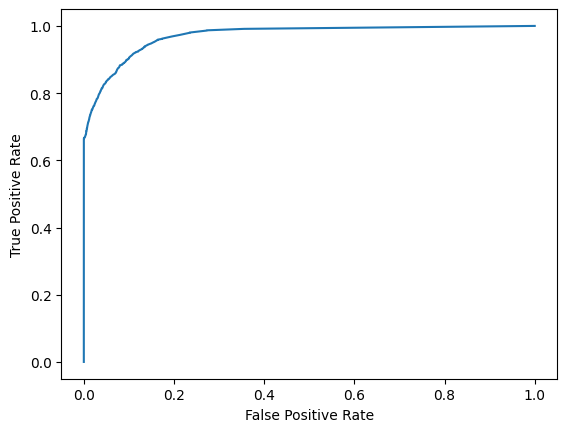

In [56]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(y_val, y_proba)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

In [138]:
import tensorflow as tf
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense, kernel_initializer="he_normal", activation="relu", kernel_regularizer=tf.keras.regularizers.L2(.003))

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=[12]),
    RegularizedDense(512),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.1),
    RegularizedDense(256),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.1),
    RegularizedDense(120),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.1),
    RegularizedDense(64),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.1),
    RegularizedDense(32),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.2),
    RegularizedDense(12),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

In [139]:
early_cb = tf.keras.callbacks.EarlyStopping(patience=15)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics= ["accuracy"])

In [140]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), callbacks=[early_cb], epochs=100)

Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.9282 - loss: 0.9533 - val_accuracy: 0.9582 - val_loss: 0.2068
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9405 - loss: 0.2573 - val_accuracy: 0.9372 - val_loss: 0.2861
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9429 - loss: 0.2331 - val_accuracy: 0.9346 - val_loss: 0.2360
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9452 - loss: 0.2284 - val_accuracy: 0.8099 - val_loss: 0.4932
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - accuracy: 0.9415 - loss: 0.2207 - val_accuracy: 0.9589 - val_loss: 0.1955
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9443 - loss: 0.2153 - val_accuracy: 0.9548 - val_loss: 0.1822
Epoch 7/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9437 - loss: 0.2099 - val_accuracy: 0.9581 - val_loss: 0.1979
Epoch 8/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 13s 6ms/step - accuracy: 0.9436 -

In [141]:
model.evaluate(X_test, y_test)

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9605 - loss: 0.1703


[0.1712736189365387, 0.9604499936103821]

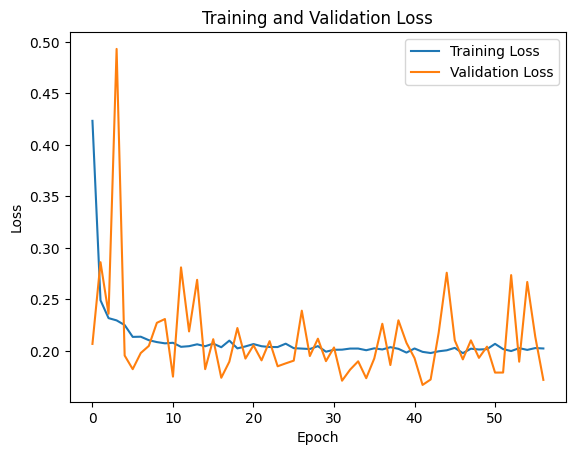

In [142]:
import matplotlib.pyplot as plt

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()